<h1 style="text-align:center">
Processing CT Scans
<h1>

In [1]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from utils import get_nodule_class, filename_from_annotation, cluster_annots
import pandas as pd

In [2]:
from PIL import Image
from gtts import gTTS
from pytesseract import image_to_string
from scipy.io.wavfile import write

from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import spectrogram

import pandas as pd
from collections import Counter
import bisect

import librosa
import librosa.display

import soundfile as sf
import io


In [2]:
MAX_NODULE_WIDTH = 47
MAX_NODULE_HEIGHT = 47
N_SLICES = 5

---
Get Masks and Cropped Images


### Normalization

Our values range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used thresholds are -1000 and 400.

**Warning**: Do not zero center with the mean per image. The CT scanners are calibrated to return accurate HU measurements.

In [4]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
    
def normalize(image):
    # Scale
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.

    # Zero mean
    image = image - PIXEL_MEAN

    return image

In [5]:
# Makes all nodules the same size
def zoomout_nodule(bbox, width, height, n_slices):
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].start - x_acres + width, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].start - y_acres + height, None)

    z_slice = np.linspace(bbox[2].start, bbox[2].stop, n_slices, endpoint=False, dtype=int)

    return (x_slice, y_slice, z_slice)

Nodules are cropped and masked before being fed to a neural network for classification for several reasons:

1. **Focus on the Region of Interest (ROI)**: By cropping around the nodule, we isolate the area of interest and remove irrelevant background information. This helps the network focus on the features of the nodule, which are crucial for accurate classification.

2. **Noise Reduction**: Medical images often contain a lot of extraneous information and noise from surrounding tissue or artifacts. Masking ensures that only the nodule is visible to the model, reducing the potential for the network to pick up on background patterns that could interfere with learning.

3. **Data Efficiency**: Feeding the network smaller, cropped images (as opposed to the entire scan) reduces the amount of data processing required. This not only decreases computational load but also allows the network to learn more efficiently since it's not wasting resources on unnecessary areas.

4. **Standardization**: Masking and cropping help standardize the input size and appearance, which is especially important in medical imaging where nodules can vary widely in size, shape, and position. Standardization allows the neural network to interpret images consistently, improving model performance and reducing the variability across samples.

5. **Improved Model Performance**: By focusing exclusively on the nodule, the models can more effectively learn features related to malignancy or other diagnostic criteria, resulting in improved classification accuracy. 

Overall, cropping and masking optimize the input to improve accuracy, reduce computational demand, and enhance the model's ability to learn meaningful features related to the nodule itself.

(slice(343, 390, None), slice(296, 343, None), array([86, 87, 89, 91, 93]))


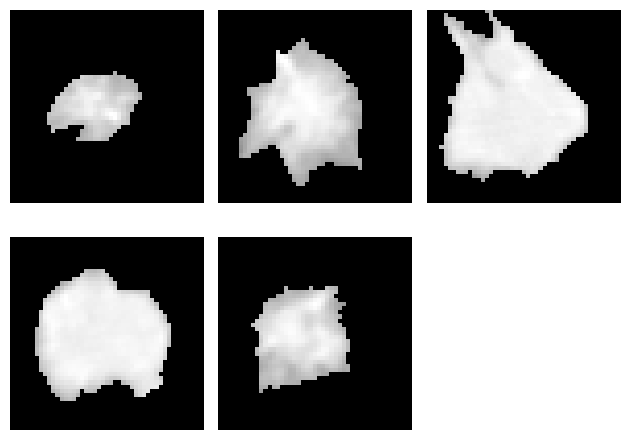

In [6]:
def get_cropped_annot(scan: pl.Scan, nods, mask: bool=False):
    if len(scan.annotations) == 0:
        return None

    vol = scan.to_volume(verbose=False)

    # Normalize values
    vol = normalize(vol)

    images = []
    masks = []
    for anns in nods:
        cmask, cbbox, _ = consensus(anns, clevel=0.5,
                                pad=[(10,10), (10,10), (0,0)])

        full_mask = np.full_like(vol, False, dtype=bool)
        full_mask[cbbox] = cmask

        cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT, N_SLICES)
        cropped = vol[cbbox]
        cropped_mask = ~full_mask[cbbox]
        if mask:
            cropped[cropped_mask] = -1

        images.append(cropped)
        masks.append(cropped_mask)

    return images, masks


scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
nods = cluster_annots(scan)
cropped, _ = get_cropped_annot(scan, nods, True)

# Set up the plot.
for i in range(N_SLICES):
    plt.subplot(2, 3, i+1)
    plt.imshow(cropped[0][:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

plt.tight_layout()
plt.show()

We process all nodules and store the results to be used later.

In [ ]:
malign_path = Path("nn_data/images/malign")
belign_path = Path("nn_data/images/belign")
undetermined_path = Path("nn_data/images/undetermined")

os.makedirs(malign_path, exist_ok=True)
os.makedirs(belign_path, exist_ok=True)
os.makedirs(undetermined_path, exist_ok=True)

scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0487').all()
for scan in scans:
    try:
        if len(scan.annotations) == 0:
            # Scan has no annotations, there is nothing to do
            continue

        print(scan.patient_id)

        nods = cluster_annots(scan)
        cropped, masks = get_cropped_annot(scan, nods, True)

        for i, anns in enumerate(nods):
            label = get_nodule_class(anns)
            if label == 0:
                continue
            
            filename = filename_from_annotation(anns[0])
            mask_filename = filename + "-mask"
            if label == 1:
                np.save(malign_path/filename, cropped[i].astype(np.float32))
                np.save(malign_path/mask_filename, masks[i].astype(np.float32))
            elif label == -1:
                np.save(belign_path/filename, cropped[i].astype(np.float32))
                np.save(belign_path/mask_filename, masks[i].astype(np.float32))
            else:
                np.save(undetermined_path/filename, cropped[i].astype(np.float32))
                np.save(undetermined_path/mask_filename, masks[i].astype(np.float32))

    except RuntimeError as e:
        print(e)

---

## SOUND

The following code is about the transformation of images to sound and the acquiring of some of its features

The goal is to try and find different patterns that hellp improve the model.

in here we are creation of a function that given a nodule, returns audio_sample and sample_rate
in this case the function returs two diferent audio samples, one of all the slices and the other for the middle slice

In [ ]:

#image_data = cropped[0][:,:,0]  
image_data = cropped[0]


def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    #img = Image.fromarray(image_data).convert('L')
    #img_data = np.array(image_data)

    ''''''


    img_data = image_data[:,:,0]
    img_data = img_data[img_data > 0]
    img_data = np.array(img_data)
    for i in range(1, N_SLICES):
        i_dat = image_data[:,:,i]
        i_dat = i_dat[i_dat>0]
        if i == 2:
            ii_data = np.array(i_dat)
        img_data = np.append(img_data, np.array(i_dat))

    


    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 0.7], [min_freq, max_freq])  #[0, 255] 
    iifrequencies = np.interp(ii_data, [0, 0.7], [min_freq, max_freq])  #[0, 255] 


    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    
    iiaudio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in iifrequencies.flatten()])

    iiaudio_data = np.int16(iiaudio_data / np.max(np.abs(iiaudio_data)) * 32767)

    return audio_data, sample_rate, iiaudio_data



def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave


ad, sr, iiad = convert_to_sound(image_data)


# image of 5 layers of the nodule of patient 0001

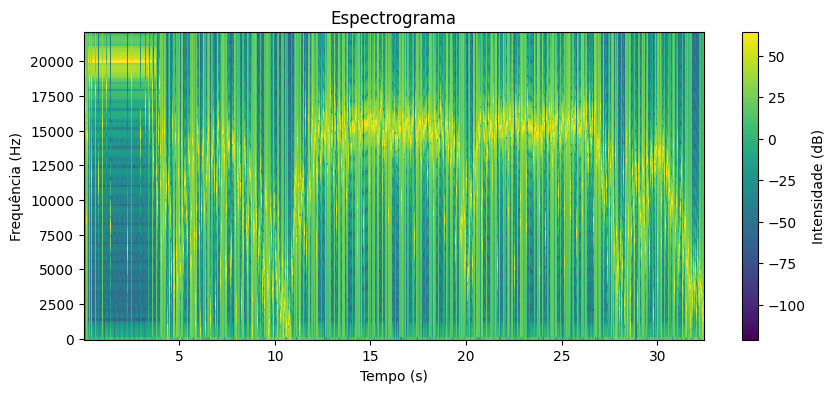

In [24]:
''' 
intencidade
frequência 
espectograma(variação das frequências)
tempo do audio
frequência fundamental
taxa de cruzamento por zero
energia
'''


#criar lista com as infos [duration, frequência fundamental, taxa de cruzamento por zero, energia]

duration = len(ad) / sr


# Análise 3: Espectrograma (Domínio da Frequência ao Longo do Tempo)
frequencies, times, Sxx = spectrogram(ad, sr)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()

# image of middle layers of the same nodule from patient 0001

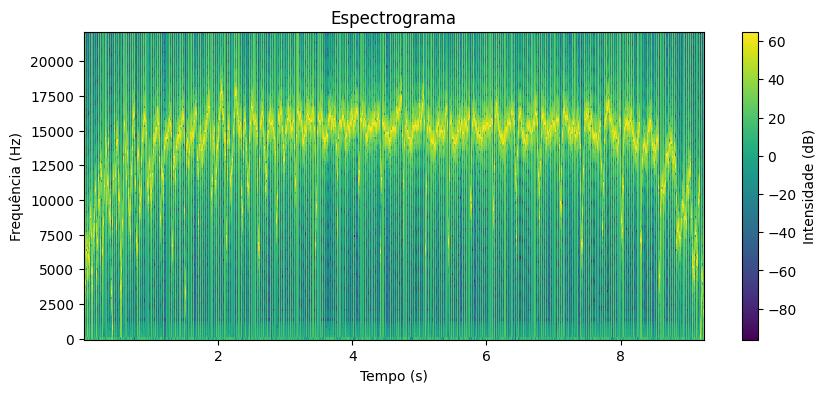

In [28]:
frequencies, times, Sxx = spectrogram(iiad, sr)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()

in this case, the first layer seems to be considerably from the rest


RNN to complicated for this progect so, we are merly using some commonly used features

# choosing features for extraction

- **ZCR:** is the rate of sign-changes along a signal(how many times the waveform crosses the zero axis within a specified time frame) this feature is used to classify percussive sounds and could also serve to detect anomalies in time-series data. It gives a representation of the smoothness of the wave

- **frequência fundamental:** fundamental frequency of a signal is the greatest common divisor (GCD) of all the frequency components contained in a signal/or/ is the lowest frequency at which a system oscillates. It can aid in identifying and classifying patterns

- **spectral centroid:** considered the center of 'gravity' of the spectrum(center of amplitude-weighted frequency distribution), it measures the spectral shape and position of the spectrum. If the spectral centroid is high, the sound is perceived as "brighter" or "sharper"

- **spectral bandwidth:** describes the width or spread of frequencies around the spectral centroid(how "wide" vs "narrow" the frequency distribution is)

- **onset times:**  refer to the moments in a sound signal where a new sound begins, or more formally, where the amplitude of the sound suddenly increases. onset_times array contains the timestamps at which new sounds begin in an audio signal

- **tempo:** annother name for speed, measured by beats per minute (BPM) 
 
- **dynamic range:** is, in this case, a base-10 logarithmic value of the difference between the largest and the smallest values 

- **energia total:** energy is proportional to the square of the amplitude, so this calculation gives a measure of the signal's power over time. this is often used in audio analysis to measure the signal's intensity or loudness

- **intencidade/amplitude**

In [ ]:
'''
various functions to extract certain features from audio_data
'''

#ZCR
def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

zcr = zero_crossing_rate(ad)
iizcr = zero_crossing_rate(iiad)

print(f'Zero Crossing Rate: {zcr:.2f}')
print(f'ii ->Zero Crossing Rate: {iizcr}')



# Energia
energia_total = np.sum(ad ** 2)

ienergia_total = np.sum(iiad ** 2)

print(f"energia total = {energia_total}")
print(f"ii ->energia total = {ienergia_total}")



def frequencia_fundamental(audio_data):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Compute the fundamental frequency (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Filter out NaN values from the fundamental frequency
    f0_filtered = f0[~np.isnan(f0)]
    
    if len(f0_filtered) > 0:
        ff = np.mean(f0_filtered)  # Mean of the fundamental frequencies
    else:
        ff = 0  # If no valid frequencies, return 0
    
    return ff

'''
ff = round(frequencia_fundamental(ad),2)
print(f'Frequência Fundamental: {ff} Hz')

iff = round(frequencia_fundamental(iiad),2)
print(f'ii ->Frequência Fundamental: {iff} Hz')
'''




def extract_spectral_features(audio_data, sample_rate):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Calculate the spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    # Calculate the spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)

    # Return the mean values for a single representative figure (you can also return the full arrays if preferred)
    centroid_mean = np.mean(spectral_centroid)
    bandwidth_mean = np.mean(spectral_bandwidth)

    return centroid_mean, bandwidth_mean

cm, bm = extract_spectral_features(ad, sr)
print(f'CM: {cm} and BM: {bm}')

icm, ibm = extract_spectral_features(iiad, sr)
print(f'ii ->CM: {icm} and BM: {ibm}')



def extract_rhythm_features(audio_data, sample_rate):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Calculate the tempo and beat frames
    tempo, beat_frames = librosa.beat.beat_track(y=audio_data, sr=sample_rate)
    # Convert beat frames to timestamps
    #no need
    #beat_times = librosa.frames_to_time(beat_frames, sr=sample_rate)

    # Detect onsets
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sample_rate)
    onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)
    num_onset = len(onset_times)

    # Inter-Onset Intervals(IOIs)
    # array of intervals between onsets
    iois = np.diff(onset_times)
    mean_ioi = np.mean(iois)
    variance_ioi = np.var(iois)

    onset_density = num_onset / (onset_times[-1] - onset_times[0])  # Onsets per second


    return tempo[0], num_onset, mean_ioi, variance_ioi, onset_density

t, no, mioi, vioi, od = extract_rhythm_features(ad, sr)
print(f't: {t}, no: {no}, mioi: {mioi}, vioi: {vioi}, od: {od}')

it, ino, imioi, ivioi, iod = extract_rhythm_features(iiad, sr)
print(f'ii ->t: {it}')



def calculate_dynamic_range(audio_data):
    # Ensure audio_data is a numpy array for efficient processing
    audio_data = np.array(audio_data)

    # Calculate the maximum and minimum values of the absolute amplitudes
    max_amplitude = np.max(np.abs(audio_data))
    min_amplitude = np.min(np.abs(audio_data[np.nonzero(audio_data)]))  # Avoid zero values

    #print(max_amplitude, min_amplitude)
    # Convert amplitudes to decibel (dB) scale
    max_db = 20 * np.log10(max_amplitude)
    min_db = 20 * np.log10(min_amplitude)

    # Dynamic range is the difference between max and min in dB
    
    dynamic_range = max_db - min_db

    return dynamic_range, max_amplitude, min_amplitude, np.mean(np.abs(audio_data))

print(f'dynamic range: {calculate_dynamic_range(ad)}')
print(f'ii ->dynamic range: {calculate_dynamic_range(iiad)}')

Zero Crossing Rate: 0.50
ii ->Zero Crossing Rate: 0.4974428443816199
int mean: 20825.02984716314
ii ->int mean: 20827.94768383544
energia total = 210594685
ii ->energia total = 80187448
CM: 10970.47392884709 and BM: 3036.948160502057
ii ->CM: 13408.44393004739 and BM: 2972.393794485227
t: 112.34714673913044, no: 371, mioi: 0.08170913770913771, vioi: 0.002045724522981578, od: 12.271610383064518
ii ->t: 112.34714673913044
dynamic range: (90.3087329864502, 32767, 1, 20825.02984716314)
ii ->dynamic range: (90.3087329864502, 32767, 1, 20827.94768383544)


' \nnotas \n->descobrir o q intencidade \n->ver relevância de duração\n->normalizar energia total e frequência fundamental\nGradient/movement (smooth vs. sharp transitions)\n'

being that the extraction of the featurs was proving itself to be a rather long process it was decided to only extrac the features from the middle layer of each nodule

In [ ]:
''' 
a mash up of the former cels, so that it is only needed to run one
'''

##2
def sound_def(image_data):
    ad, sr = convert_to_sound(image_data)

    #no fim sum the lists
    #[ZCR, energia total, dynamic_range, max_amp, min_amp, mean_amp]
    list = [((ad[:-1] * ad[1:]) < 0).sum() / len(ad), np.sum(ad ** 2)]

    for i in calculate_dynamic_range(ad):
        list.append(i)

    # Ensure the audio data is in floating-point format
    if ad.dtype != np.float32 and ad.dtype != np.float64:
        ad = ad.astype(np.float32) / np.max(np.abs(ad))  # Normalize to [-1.0, 1.0]


    #FF
    for i in calculate_ff_sf_rf(ad, sr):
        list.append(i)


    #[ZCR, energia total, dynamic_range, max_amp, min_amp, mean_amp, ff, centroid_mean, bandwidth_mean, tempo, num_onset, mean_ioi, variance_ioi, onset_density]


    return list



##1
def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    
    # Aglumerating all layers of the scann

    #alterar para obter apenas a camada do meio
    k = int(image_data.shape[2]/2)
    img_data = image_data[:,:,k]
    img_data = img_data[img_data > 0]
    img_data = np.array(img_data)


    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 0.7], [min_freq, max_freq])  #[0, 255] 

    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])
    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)


    return audio_data, sample_rate





def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave


######################

def calculate_dynamic_range(audio_data):
    # Ensure audio_data is a numpy array for efficient processing
    audio_data = np.array(audio_data)

    # Calculate the maximum and minimum values of the absolute amplitudes
    max_amplitude = np.max(np.abs(audio_data))
    min_amplitude = np.min(np.abs(audio_data[np.nonzero(audio_data)]))  # Avoid zero values

    #print(max_amplitude, min_amplitude)
    # Convert amplitudes to decibel (dB) scale
    max_db = 20 * np.log10(max_amplitude)
    min_db = 20 * np.log10(min_amplitude)

    # Dynamic range is the difference between max and min in dB
    
    dynamic_range = max_db - min_db

    return dynamic_range, max_amplitude, min_amplitude, np.mean(np.abs(audio_data))





def calculate_ff_sf_rf(audio_data, sample_rate):

    ## Compute the fundamental frequency (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Filter out NaN values from the fundamental frequency
    f0_filtered = f0[~np.isnan(f0)]
    
    if len(f0_filtered) > 0:
        ff = np.mean(f0_filtered)  # Mean of the fundamental frequencies
    else:
        ff = 0  # If no valid frequencies, return 0




    ## Calculate spectral features
    # Calculate the spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    # Calculate the spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)

    # Return the mean values for a single representative figure (you can also return the full arrays if preferred)
    centroid_mean = np.mean(spectral_centroid)
    bandwidth_mean = np.mean(spectral_bandwidth)



    ## Rhythm features
    tempo, beat_frames = librosa.beat.beat_track(y=audio_data, sr=sample_rate)

    # Detect onsets
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sample_rate)
    onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)
    num_onset = len(onset_times)

    # Inter-Onset Intervals(IOIs)
    # array of intervals between onsets
    iois = np.diff(onset_times)
    mean_ioi = np.mean(iois)
    variance_ioi = np.var(iois)

    onset_density = num_onset / (onset_times[-1] - onset_times[0])  # Onsets per second

    
    return round(ff,2), centroid_mean, bandwidth_mean, tempo[0], num_onset, mean_ioi, variance_ioi, onset_density




In [ ]:
''' 
create a csv of the sound_data
'''

import csv
import SimpleITK as sitk
import librosa


data = []
for patient_dir in os.listdir('./data_cleaned_2'):
    patient_path = os.path.join('./data_cleaned_2', patient_dir)
    print(patient_dir)
    for nodule_dir in os.listdir(patient_path):
        nod_id = str(nodule_dir) 

        nodule_path = os.path.join(patient_path, nodule_dir)

        
        image_path = os.path.join(nodule_path, 'image', 'image.nii')
        mask_path = os.path.join(nodule_path, 'mask', 'mask.nii')
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
            image[mask] = -1
            features = sound_def(image)
            features.append(nod_id)
            data.append(features)
        
# writing data to a CSV file
with open('sound_data_5.csv', 'w', newline='') as csvfile:

    csvwriter = csv.writer(csvfile)

    #[ZCR, intencidade média, intensidade máxima, energia total, frequência fundamental]
    #csvwriter.writerow(['ZCR', 'intencidade média', 'intensidade máxima', 'energia total', 'frequência fundamental'])  # Customize as needed
    #[ZCR, energia total, dynamic_range, max_amp, min_amp, mean_amp, ff, centroid_mean, bandwidth_mean, tempo, num_onset, mean_ioi, variance_ioi, onset_density]
    csvwriter.writerow(['nod_id','ZCR', 'energia total', 'dynamic_range', 'max_amp', 'min_amp', 'mean_amp', 'ff', 
                        'centroid_mean', 'bandwidth_mean', 'tempo', 'num_onset', 'mean_ioi', 'variance_ioi', 'onset_density',])  # Customize as needed
    
    csvwriter.writerows(data)

In [1]:
import pandas as pd
sound_df = pd.read_csv('sound.csv')
sound_df

,Unnamed: 0,onset_density,ZCR,energia total,dynamic_range,max_amp,min_amp,mean_amp,ff,centroid_mean,bandwidth_mean,tempo,num_onset,mean_ioi,variance_ioi,ID
0,0,0.497801,127333175,90.308733,32767,1,20833.326869,1295.57,5566.717143,3510.192856,161.499023,150,0.098958,0.003393,10.173167,1338
1,1,0.497630,73059890,90.308733,32767,1,20834.284890,1196.93,4406.960035,3436.754457,206.718750,68,0.111941,0.008106,9.066612,1339
2,2,0.497730,551525482,90.308733,32767,1,20832.898835,2524.62,6012.193588,3448.115361,143.554688,426,0.159262,0.014823,6.293753,5630
3,3,0.496403,59409632,90.308733,32767,1,20830.733166,1279.99,4559.221271,3538.758582,105.468750,89,0.084964,0.002002,11.903448,5627
4,4,0.496233,55088763,90.308733,32767,1,20832.581357,2084.03,7743.259086,3205.973971,105.468750,93,0.075086,0.001464,13.462776,5628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,1222,0.497267,195706414,90.308733,32767,1,20833.786156,1597.67,6657.358305,3416.003831,129.199219,273,0.080886,0.001754,12.408579,4482
2682,1223,0.496336,393252983,90.308733,32767,1,20830.328123,1431.05,5048.883787,3376.017725,82.031250,383,0.098806,0.003541,10.147298,4483
2683,1224,0.497931,229372374,90.308733,32767,1,20833.947822,1186.47,5081.419418,3519.292184,112.347147,176,0.143831,0.008988,6.992332,4484
2684,1225,0.498215,64993158,90.308733,32767,1,20832.664431,1376.39,4129.192106,3382.617581,103.359375,103,0.076148,0.001199,13.261106,4491


### References

- www.sciencedirect.com. (n.d.). Zero Crossing Rate - an overview | ScienceDirect Topics. [online] Available at: https://www.sciencedirect.com/topics/engineering/zero-crossing-rate.

- Wikipedia. (2021). Zero-crossing rate. [online] Available at: https://en.wikipedia.org/wiki/Zero-crossing_rate.

- LEARN STATISTICS EASILY. (2024). What is: Zero Crossing Rate. [online] Available at: https://statisticseasily.com/glossario/what-is-zero-crossing-rate/ [Accessed 2 Nov. 2024].

- Archive.org. (2014). Wayback Machine. [online] Available at: https://web.archive.org/web/20140514122624/http://fourier.eng.hmc.edu/e101/lectures/Fundamental_Frequency.pdf [Accessed 2 Nov. 2024].

- www.sciencedirect.com. (n.d.). Spectral Centroid - an overview | ScienceDirect Topics. [online] Available at: https://www.sciencedirect.com/topics/engineering/spectral-centroid.

- www.sciencedirect.com. (n.d.). Spectral Bandwidth - an overview | ScienceDirect Topics. [online] Available at: https://www.sciencedirect.com/topics/engineering/spectral-bandwidth.

- Acousticslab.org. (2024). Fundamentals of Sound - Module 06. [online] Available at: http://acousticslab.org/RECA220/PMFiles/Module06.htm#timbreb [Accessed 2 Nov. 2024].


- The Online Metronome (n.d.). Common Tempo Markings in Music | the Online Metronome. [online] theonlinemetronome.com. Available at: https://theonlinemetronome.com/blogs/12/tempo-markings-defined.